In [7]:
import torch 
import numpy as np
import sys
import matplotlib.pyplot as plt 
from torch.func import vmap, grad
from tqdm import tqdm
from torch.distributions import MultivariateNormal
sys.path.append("..\\")
plt.style.use("dark_background")
device = "cuda" if torch.cuda.is_available() else "cpu"
from score_models import ScoreModel, NCSNpp
import json
file = open("../ncsnpp_probes_g_64_230604024652/model_hparams.json")
model_hparams = json.load(file)
sigma_min, sigma_max = model_hparams["sigma_min"], model_hparams["sigma_max"]

In [8]:
def preprocess_probes_g_channel(img, inv_link = False):  # channel 0
    img = torch.clamp(img, 0, 1.48)
    
    if inv_link:
        img = 2 * img / 1.48 - 1.
    return img

def link_function(x):
    return (x + 1)/2



In [3]:
score_model = ScoreModel(checkpoints_directory="../ncsnpp_probes_g_64_230604024652")
img = score_model.sample(1, shape = (1, 64, 64), steps = 500)

100%|██████████| 500/500 [00:27<00:00, 18.42it/s]


### Implementing for the DFT matrix

In [4]:
def ft(x): 
    return torch.fft.fft2(x, norm = "ortho")

def ift(x): 
    return torch.fft.ifft2(x, norm = "ortho")

torch.Size([8192])


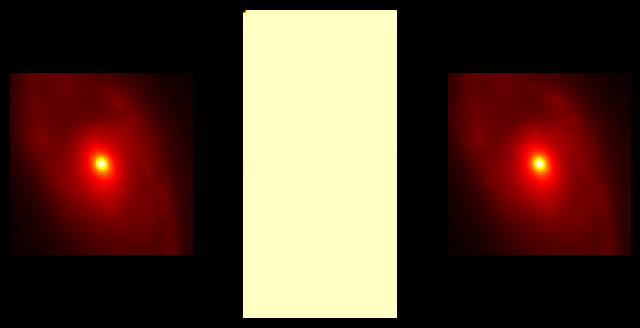

In [15]:
x = img[0,0, ...]
img_size = x.shape[-1]
sigma_likelihood = 1e-1
dist_likelihood = MultivariateNormal(loc = torch.zeros(2 * img_size**2, device = x.device), covariance_matrix=sigma_likelihood ** 2 *torch.eye(2 * img_size**2, device = x.device))
eta = dist_likelihood.sample([])

ft_x = ft(x).flatten()
ft_x = torch.cat([ft_x.real, ft_x.imag])
y = ft_x + eta
#y = preprocess_probes_g_channel(y, inv_link = False)
y_dim = len(y)

print(y.shape)
# Checking if I do something wrong
fig, axs = plt.subplots(1, 3, figsize = (8, 4))
for i in range(len(axs)): 
    axs[i].axis("off")

axs[0].imshow(x.reshape(-1, img_size).cpu(), cmap = "hot")
axs[1].imshow(y.reshape(-1, img_size).cpu(), cmap = "hot")

y_rep = y[:img_size**2] + 1j * y[img_size**2:]
axs[2].imshow(ift(y_rep.reshape(img_size, img_size)).real.cpu(), cmap = "hot")

In [6]:
y.shape

torch.Size([8192])

In [16]:
def sigma(t): 
    return sigma_min * (sigma_max/sigma_min) ** t

def logprob_likelihood(x, cov_mat): 
    dist = torch.distributions.MultivariateNormal(loc = torch.zeros(y_dim, device = x.device), covariance_matrix = cov_mat, validate_args=False)
    return dist.log_prob(x)


def model(x):
    f = link_function(x)
    f = ft(x.reshape(img_size, img_size)).flatten()
    f = torch.cat([f.real, f.imag])
    return f

def score_likelihood(x, t): 
    return vmap(grad(lambda x, t: logprob_likelihood(y- model(x),  (sigma_likelihood ** 2 + sigma(t)**2) * torch.eye(y_dim, device = x.device))))(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    return score_model.score(t, x.reshape(-1, 1, img_size, img_size)).flatten(start_dim = 1) + score_likelihood(x, t)

x = torch.randn([2, img_size ** 2]).to(device) 
t = torch.ones([2]).to(device)

print((torch.sum(score_likelihood(x, t)**2))**0.5)
print(score_posterior(x, t))
#score_model.score(t, x.reshape(-1, 1, img_size, img_size)).shape 

tensor(0.0007, device='cuda:0')
tensor([[ 0.0004, -0.0003, -0.0013,  ..., -0.0009,  0.0006, -0.0017],
        [ 0.0039, -0.0014,  0.0011,  ...,  0.0001,  0.0011, -0.0027]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [17]:

def g(t): 
    return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))

"""
def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x)
            x_mean  = x + (-0.5 * beta(t) * x - beta(t) * gradient) * dt 
            noise = (beta(t) * -dt) ** 0.5 * z 
            x = x_mean + noise
            t += dt
    return x_mean
"""
def euler_sampler(num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = sigma_max * torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_steps - 1)): 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
    # DONT FORGET TO APPLY THE LINK FUNCTION
    return x_mean


#pc_samples = pc_sampler(num_samples = 100, num_pred_steps = 500, num_corr_steps = 20, snr = 1e-2, score_function = score_posterior, img_size = 28)
euler_samples = euler_sampler(num_samples = 1, num_steps = 500, score_function = score_posterior, img_size = img_size)


100%|██████████| 499/499 [02:01<00:00,  4.12it/s]


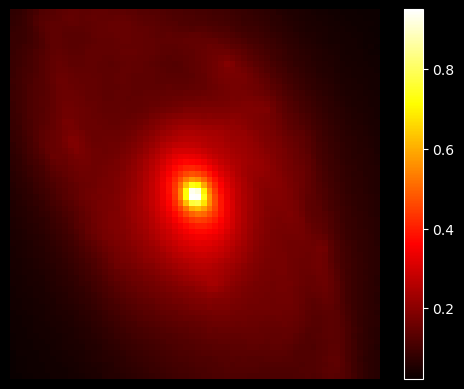

In [18]:
n_images = len(euler_samples)

if n_images != 1:
    fig, axs = plt.subplots(1, n_images, figsize = (8, 4))

    for i in range(n_images): 
        axs[i].imshow(x[i].cpu().reshape(img_size, img_size), cmap = "hot")
        axs[i].axis("off")
else: 
    plt.imshow(link_function(euler_samples).cpu().reshape(img_size, img_size), cmap = "hot")
    plt.axis("off")
    plt.colorbar(fraction = 0.046)

In [89]:
euler_samples.max()

tensor(-0.2728, device='cuda:0')